<a href="https://colab.research.google.com/github/maha-alarifi/Aligatou_AI/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to Algatou_AI's CycleGAN Impelmentation

We build this notebook based on the [Tenserflow CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) implementation of CycleGAN. And apply changes to make it work with our own use case.



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-6tm9c4t0
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-6tm9c4t0
  Created wheel for tensorflow-examples: filename=tensorflow_examples-169aaf3284df3a4713255609c7e6155a32cee4f0_-cp36-none-any.whl size=96801 sha256=32406f0d824ac12066828efb0f27f8aae9feb1770107d4c61fe9987f70a96f31
  Stored in directory: /tmp/pip-ephem-wheel-cache-ucvk4lj6/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import imageio
import glob
from PIL import Image
import numpy as np

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Data Preperation

In [0]:
IMG_HEIGHT = IMG_WIDTH = 256
BATCH_SIZE = 1
BUFFER_SIZE = 1000

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = 2.0 * tf.image.convert_image_dtype(img, tf.float32) - 1.0
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img


###Train Datasets
Since the CycleGAN need two distinguished datasets `(A/B)`, We prepared two original datasets. 
- `A` - The first dataset is the original patterns drawn by our artist, this datasets conssists of 121 images and augmented to become `500 images`.
- `B` - The second dataset is the outline of the segmentation of the original drawn. Also augmented to become `500 images`.

In [0]:
## Please note that this is path is inside our own drive and you may need to insert 
## your own dataset path to make this cell run correctly
data_path_A = "/content/drive/My Drive/AiDataset_February_21/OD/output/*.png"
list_ds_A = tf.data.Dataset.list_files(str(data_path_A))

train_datasetA = list_ds_A.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)
train_datasetA = train_datasetA.batch(BATCH_SIZE)

data_path_B = "/content/drive/My Drive/AiDataset_February_21/OW/output/*.png"
list_ds_B = tf.data.Dataset.list_files(str(data_path_B))

train_datasetB = list_ds_B.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)
train_datasetB = train_datasetB.batch(BATCH_SIZE)

###Test Datasets
These testing datasets are the original drawing colored and outlined
The aim of this testing datasets is to see what the model is doing to the original un-augmented datasets

In [0]:
## Please note that this is path is inside our own drive and you may need to insert 
## your own dataset path to make this cell run correctly
data_path_C = "/content/drive/My Drive/AiDataset_February_21/OD/*.png"
list_ds_C = tf.data.Dataset.list_files(str(data_path_C))

test_dataset_C = list_ds_C.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)
test_dataset_C = test_dataset_C.batch(BATCH_SIZE)

data_path_D = "/content/drive/My Drive/AiDataset_February_21/OW/*.png"
list_ds_D = tf.data.Dataset.list_files(str(data_path_D))

test_dataset_D = list_ds_D.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE)
test_dataset_D = test_dataset_D.batch(BATCH_SIZE)

**Samples Images**

In [0]:
sample_A = next(iter(train_datasetA))
sample_B = next(iter(train_datasetB))

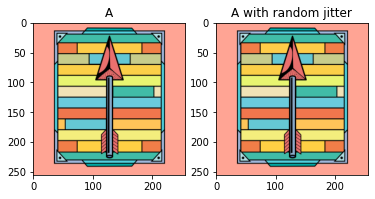

In [0]:
plt.title('sample_A')
plt.imshow(sample_A[0] * 0.5 + 0.5)

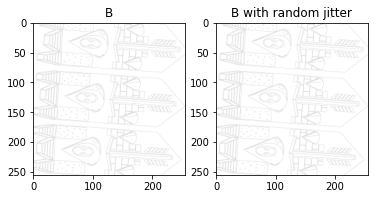

In [0]:
plt.title('sample_B')
plt.imshow(sample_B[0] * 0.5 + 0.5)

##Importing Pretrained Models

As it shows in this step this strucure of CycleGAN is based on the implementation of pix2pix model that is provided in the tenserflow examples

In [0]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

**Testing the imported modesl**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


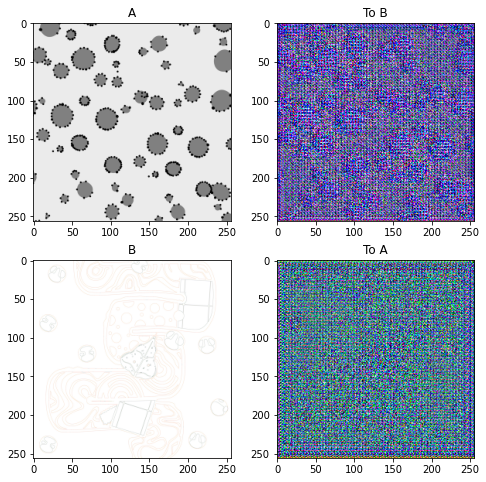

In [12]:
to_B = generator_g(sample_A)
to_A = generator_f(sample_B)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_A, to_B, sample_B, to_A]
title = ['A', 'To B', 'B', 'To A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

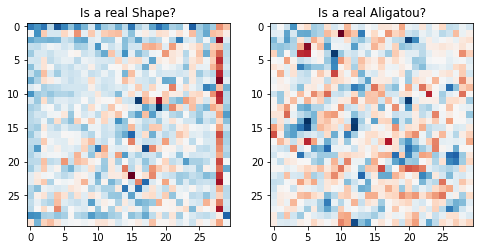

In [13]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Shape?')
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Aligatou?')
plt.imshow(discriminator_x(sample_A)[0, ..., -1], cmap='RdBu_r')

plt.show()

**Setting the loss functions**



In [0]:
LAMBDA = 15 #this value is just right for us 

In [0]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**Improt the latest checkpoint**

In [0]:
checkpoint_path = "/content/drive/My Drive/TrainedModels/ODxOW"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=100)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

##Training Preperation

**Generating an Image**

In [0]:
def generate_images(model, test_input, epoch, g):
  prediction = model(test_input)
    
  plt.figure(figsize=(8, 8))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Generated Image']

  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    # plt.imshow(prediction[0])
    # plt.axis('off')

  plt.savefig('{}_image_at_epoch_{:04d}.png'.format(g, epoch))
  plt.show()

**Training Step**

In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

**Training Loop**

In [0]:
EPOCHS = 30

In [0]:
test_A = []
test_B = []

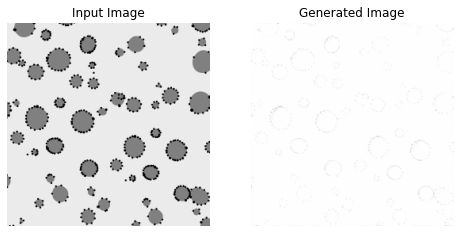

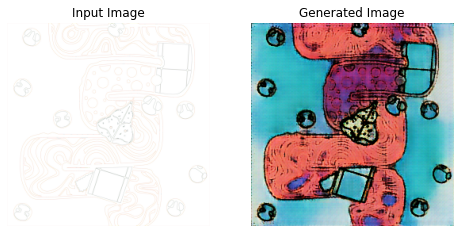

Saving checkpoint for epoch 30 at /content/drive/My Drive/TrainedModels/ODxOW/ckpt-5
Time taken for epoch 30 is 163.07810759544373 sec



In [30]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_datasetA, train_datasetB)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_A) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_A, epoch, 'A')
  generate_images(generator_f, sample_B, epoch, 'B')
  

  if (epoch + 1) % 10 == 0:
    for i in test_dataset_C:
      test_A.append(generator_g(i).numpy()) 
      
    for i in test_dataset_D:
      test_B.append(generator_f(i).numpy())

    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


## Exporting Generated Images

In [0]:
for i in range(len(test_B)):
  img = Image.fromarray((test_B[i].reshape(test_B[i].shape[1:])*255).astype(np.uint8))
  img.save('/content/drive/My Drive/AiDataset_February_21/Test/50/OD_OW_{:04d}.png'.format(i))

In [0]:
for i in range(len(test_A)):
  img = Image.fromarray((test_A[i].reshape(test_A[i].shape[1:])*255).astype(np.uint8))
  img.save('/content/drive/My Drive/AiDataset_February_21/output_CycleGAN_v2_100/A_{:04d}.png'.format(i))